## Compare CatBoost in the case of binary class (Sell, Buy)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline

In [2]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [3]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [4]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [5]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [6]:
interest_rate = wk_df["r"].values

### Functions

In [7]:
def display_report(y_test: np.ndarray, predictions: np.ndarray) -> None:
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    return

In [8]:
def plot_feature_imp(coefficients: np.ndarray[float], columns: list[str]) -> None:
    feature_importance = pd.DataFrame(
        {"Feature": columns, "Importance": np.abs(coefficients)}
    )
    feature_importance = feature_importance.sort_values("Importance", ascending=True)
    feature_importance.plot(x="Feature", y="Importance", kind="barh", figsize=(10, 6))
    plt.show()
    return

## Baseline Random Forest Classifier without new data + r

In [9]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [10]:
orig_df["r"] = interest_rate

### In sample predictions

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=True
)

### Hyper-parameters tuning using Optuna

In [12]:
# Adapted from https://github.com/optuna/optuna-examples/blob/main/catboost/catboost_pruning.py
def objective(trial: optuna.Trial) -> float:
    param = {
        "objective": trial.suggest_categorical(
            "objective", ["Logloss", "CrossEntropy"]
        ),
        "colsample_bylevel": trial.suggest_float(
            "colsample_bylevel", 0.01, 0.1, log=True
        ),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical(
            "boosting_type", ["Ordered", "Plain"]
        ),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
        "eval_metric": "Accuracy",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    model = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
            (
                "rf",
                CatBoostClassifier(
                    **param, silent=True, early_stopping_rounds=50, random_state=1968
                ),
            ),
        ]
    )

    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1968)

    return cross_val_score(
        model, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=1
    ).mean()

In [13]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-12 06:36:48,624] A new study created in memory with name: no-name-8ca81c57-e850-4414-8ae5-7ec7689efd26
[I 2024-02-12 06:36:56,198] Trial 0 finished with value: 0.598792828685259 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.020772954356028255, 'learning_rate': 0.05413976926744015, 'depth': 9, 'boosting_type': 'Ordered', 'l2_leaf_reg': 9, 'min_data_in_leaf': 28, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.3418532319733014}. Best is trial 0 with value: 0.598792828685259.
[I 2024-02-12 06:36:57,739] Trial 1 finished with value: 0.5778725099601594 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.023852324918369257, 'learning_rate': 0.03366632595495087, 'depth': 12, 'boosting_type': 'Plain', 'l2_leaf_reg': 5, 'min_data_in_leaf': 14, 'bootstrap_type': 'Bernoulli', 'subsample': 0.19724415155492395}. Best is trial 0 with value: 0.598792828685259.
[I 2024-02-12 06:37:04,312] Trial 2 finished with value: 0.5708645418326693 and parameter

Number of finished trials: 150
Best trial:
  Value: 0.7186215139442231
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.09977355842336759
    learning_rate: 0.08250237659822596
    depth: 9
    boosting_type: Plain
    l2_leaf_reg: 5
    min_data_in_leaf: 100
    bootstrap_type: MVS


In [14]:
print("Best hyperparameters:", study.best_params)
print("Best score:", study.best_value)

Best hyperparameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09977355842336759, 'learning_rate': 0.08250237659822596, 'depth': 9, 'boosting_type': 'Plain', 'l2_leaf_reg': 5, 'min_data_in_leaf': 100, 'bootstrap_type': 'MVS'}
Best score: 0.7186215139442231


In [15]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", CatBoostClassifier(**study.best_params, silent=True)),
    ]
)

In [16]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 <catboost.core.CatBoostClassifier object at 0x137956950>)])

In [17]:
predictions = pipe.predict(X_test)

In [18]:
pipe.score(X_test, y_test)

0.6932270916334662

              precision    recall  f1-score   support

           0       0.67      0.72      0.70       123
           1       0.71      0.66      0.69       128

    accuracy                           0.69       251
   macro avg       0.69      0.69      0.69       251
weighted avg       0.69      0.69      0.69       251



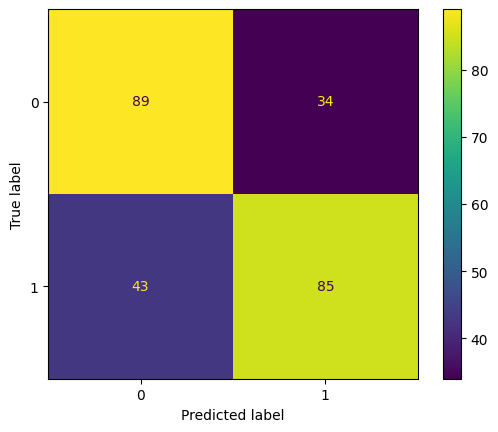

In [19]:
display_report(y_test, predictions)

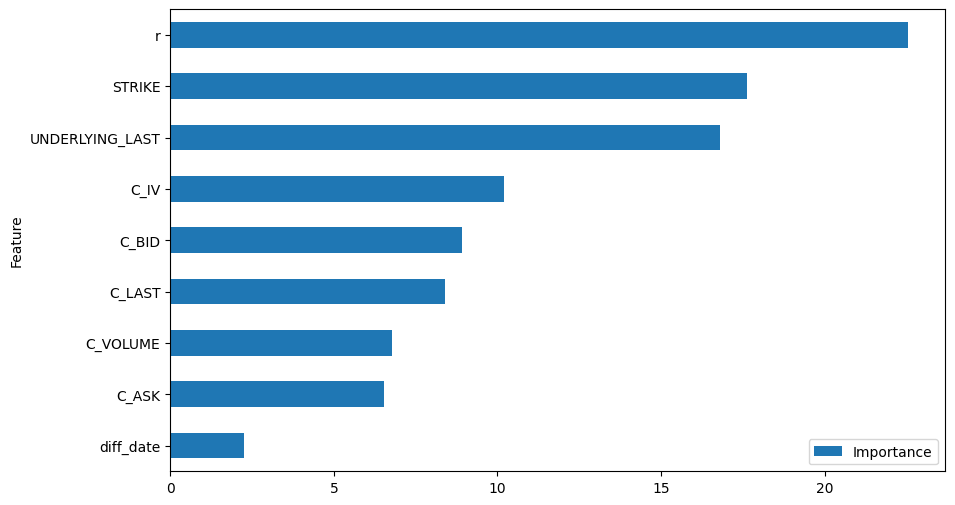

In [20]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [21]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_in"])

### Backtesting

In [22]:
strategy = []
date_idx = []
prev_price = 0.0
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = X_test.iloc[-i, :].to_dict()
    quote_date = X_test.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except KeyError:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [23]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

strategy_df = strategy_df.sort_index()

In [24]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [25]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2018-02-05,0,265.0,8.22,2018-02-28,271.649994,0.000000,-1.570006,0.000000,-1.570006
2018-02-22,0,270.0,4.26,2018-03-14,275.299988,0.000000,1.039988,0.000000,-0.530018
2018-03-08,0,274.0,2.85,2018-03-29,263.149994,0.000000,-2.850000,0.000000,-3.380018
2018-03-09,0,279.0,2.47,2018-03-29,263.149994,0.000000,-2.470000,0.000000,-5.850018
2018-04-03,1,260.5,5.09,2018-04-23,266.570007,0.980007,0.980007,0.980007,-4.870011
...,...,...,...,...,...,...,...,...,...
2022-10-25,0,385.0,10.50,2022-11-14,395.119995,0.000000,-0.380005,414.019900,389.189830
2022-11-01,1,385.0,9.48,2022-11-21,394.589996,0.109996,0.109996,414.129896,389.299827
2022-11-02,0,375.0,10.19,2022-11-23,402.420013,0.000000,17.230013,414.129896,406.529840


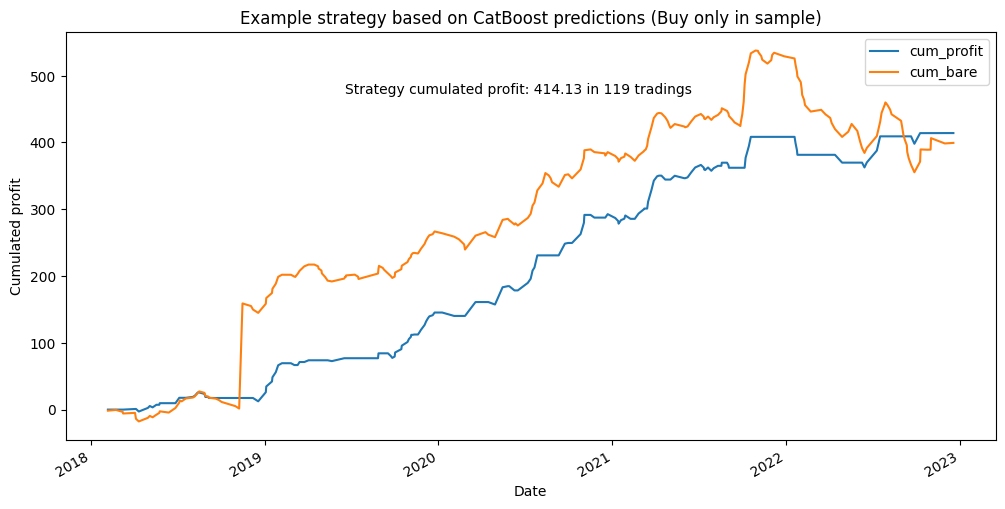

In [26]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on CatBoost predictions (Buy only in sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

### Out-of-sample predictions

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df.values,
    target.values.flatten(),
    test_size=0.2,
    random_state=1968,
    shuffle=False,
)

In [28]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", CatBoostClassifier(**study.best_params, silent=True)),
    ]
)

In [29]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 <catboost.core.CatBoostClassifier object at 0x137ba8fd0>)])

In [30]:
predictions = pipe.predict(X_test)

In [31]:
pipe.score(X_test, y_test)

0.5936254980079682

              precision    recall  f1-score   support

           0       0.68      0.80      0.74       177
           1       0.17      0.09      0.12        74

    accuracy                           0.59       251
   macro avg       0.42      0.45      0.43       251
weighted avg       0.53      0.59      0.55       251



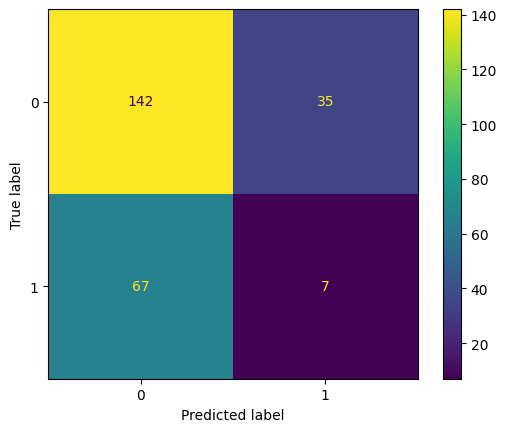

In [32]:
display_report(y_test, predictions)

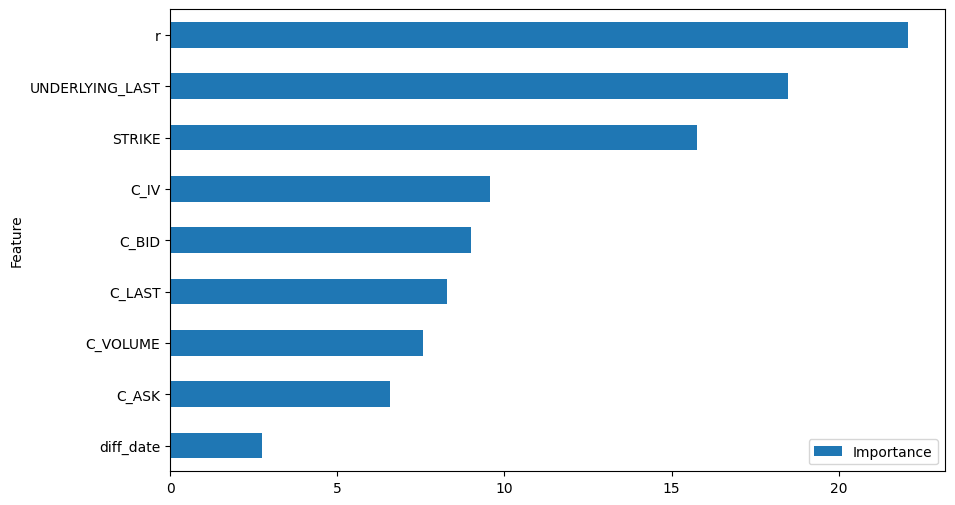

In [33]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [34]:
compare_df["bare_rf_pred_out"] = predictions

### Backtesting

In [35]:
strategy = []
date_idx = []
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = orig_df.iloc[-i, :].to_dict()
    quote_date = orig_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    final_price = spy.loc[exp_date, "Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [36]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

In [37]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [38]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-01-03,0,478.0,4.81,2022-01-24,439.839996,0.0,-4.810000,0.000000,-4.810000
2022-01-04,0,478.0,4.80,2022-01-24,439.839996,0.0,-4.800000,0.000000,-9.610000
2022-01-05,0,468.0,8.14,2022-01-26,433.380005,0.0,-8.140000,0.000000,-17.750000
2022-01-06,0,468.0,7.00,2022-01-26,433.380005,0.0,-7.000000,0.000000,-24.750000
2022-01-07,0,466.0,7.56,2022-01-28,441.950012,0.0,-7.560000,0.000000,-32.310000
...,...,...,...,...,...,...,...,...,...
2022-12-23,0,383.0,8.00,2023-01-13,398.500000,0.0,7.500000,-228.590001,-525.980022
2022-12-26,0,383.0,7.96,2023-01-13,398.500000,0.0,7.540000,-228.590001,-518.440022
2022-12-28,0,377.0,8.75,2023-01-20,395.880005,0.0,10.130005,-228.590001,-508.310017


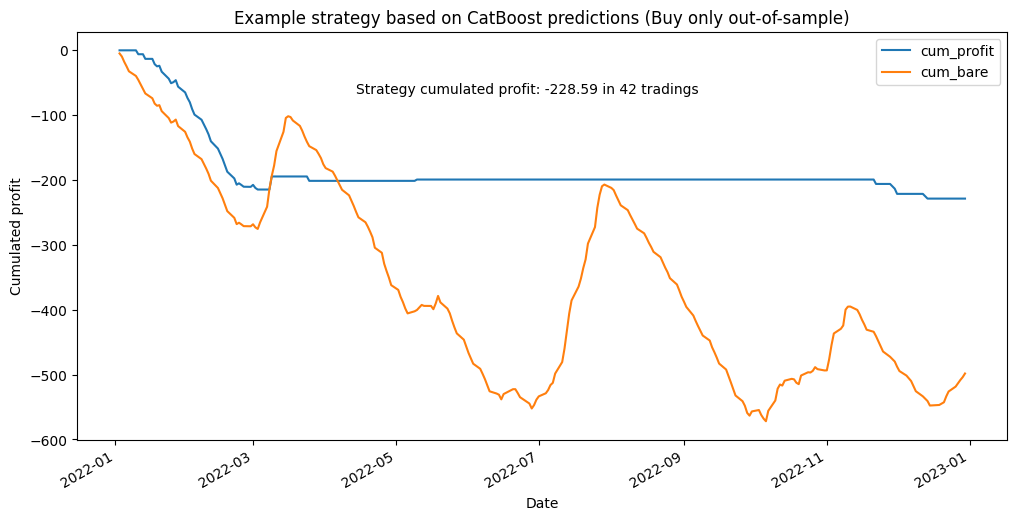

In [39]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on CatBoost predictions (Buy only out-of-sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

## CatBoost with data from MC simulation and additional features

In [40]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [41]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### In-sample predictions

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=True
)

### Hyper-parameters tuning using Optuna

In [43]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-12 06:44:44,937] A new study created in memory with name: no-name-9e7fee0c-049d-45fb-a46d-568d73db2205
[I 2024-02-12 06:44:47,072] Trial 0 finished with value: 0.5628486055776893 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.01623004977037712, 'learning_rate': 0.004382140197495923, 'depth': 2, 'boosting_type': 'Plain', 'l2_leaf_reg': 3, 'min_data_in_leaf': 97, 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.5628486055776893.
[I 2024-02-12 06:45:09,861] Trial 1 finished with value: 0.7016334661354582 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07968956993355655, 'learning_rate': 0.04224392498401555, 'depth': 9, 'boosting_type': 'Ordered', 'l2_leaf_reg': 10, 'min_data_in_leaf': 29, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.512263960477098}. Best is trial 1 with value: 0.7016334661354582.
[I 2024-02-12 06:45:17,400] Trial 2 finished with value: 0.5598725099601594 and parameters: {'objective': 'CrossEntropy', 'colsa

Number of finished trials: 91
Best trial:
  Value: 0.7724661354581674
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.06513390825130173
    learning_rate: 0.0996622830340625
    depth: 9
    boosting_type: Plain
    l2_leaf_reg: 6
    min_data_in_leaf: 37
    bootstrap_type: MVS


In [44]:
print("Best hyperparameters:", study.best_params)
print("Best score:", study.best_value)

Best hyperparameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.06513390825130173, 'learning_rate': 0.0996622830340625, 'depth': 9, 'boosting_type': 'Plain', 'l2_leaf_reg': 6, 'min_data_in_leaf': 37, 'bootstrap_type': 'MVS'}
Best score: 0.7724661354581674


In [45]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", CatBoostClassifier(**study.best_params, silent=True)),
    ]
)

In [46]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 <catboost.core.CatBoostClassifier object at 0x1379bdf10>)])

In [47]:
predictions = pipe.predict(X_test)

In [48]:
pipe.score(X_test, y_test)

0.7529880478087649

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       123
           1       0.78      0.71      0.75       128

    accuracy                           0.75       251
   macro avg       0.76      0.75      0.75       251
weighted avg       0.76      0.75      0.75       251



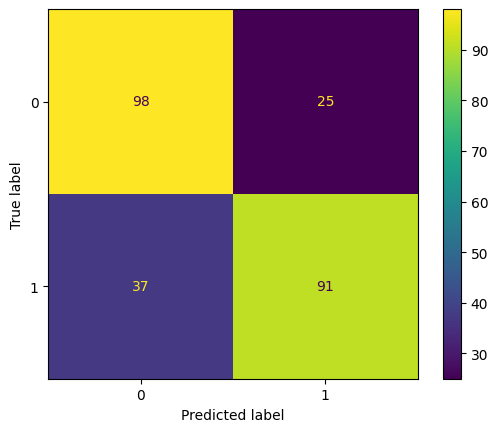

In [49]:
display_report(y_test, predictions)

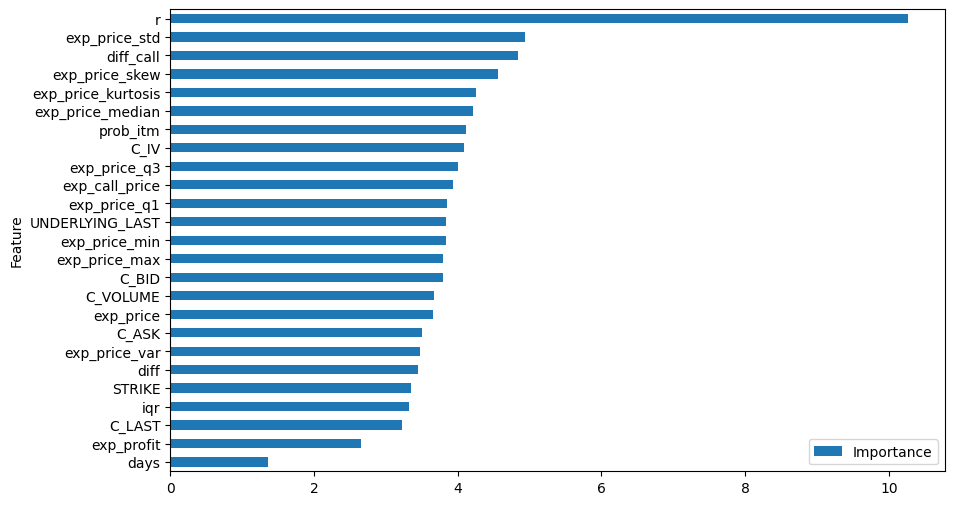

In [50]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [51]:
compare_df["mmar_rf_pred_in"] = predictions

### Backtesting

In [52]:
strategy = []
date_idx = []
prev_price = 0.0
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = X_test.iloc[-i, :].to_dict()
    quote_date = X_test.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except KeyError:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [53]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

strategy_df = strategy_df.sort_index()

In [54]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [55]:
strategy_df

,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,,
2018-02-05,0,265.0,8.22,4.942161,2018-02-28,271.649994,0.000000,-1.570006,0.000000,-1.570006
2018-02-22,1,270.0,4.26,6.397086,2018-03-14,275.299988,1.039988,1.039988,1.039988,-0.530018
2018-03-08,0,274.0,2.85,5.917690,2018-03-29,263.149994,0.000000,-2.850000,1.039988,-3.380018
2018-03-09,0,279.0,2.47,5.505012,2018-03-29,263.149994,0.000000,-2.470000,1.039988,-5.850018
2018-04-03,1,260.5,5.09,5.247430,2018-04-23,266.570007,0.980007,0.980007,2.019995,-4.870011
...,...,...,...,...,...,...,...,...,...,...
2022-10-25,0,385.0,10.50,9.062317,2022-11-14,395.119995,0.000000,-0.380005,493.679829,389.189830
2022-11-01,1,385.0,9.48,8.719475,2022-11-21,394.589996,0.109996,0.109996,493.789825,389.299827
2022-11-02,0,375.0,10.19,8.901524,2022-11-23,402.420013,0.000000,17.230013,493.789825,406.529840


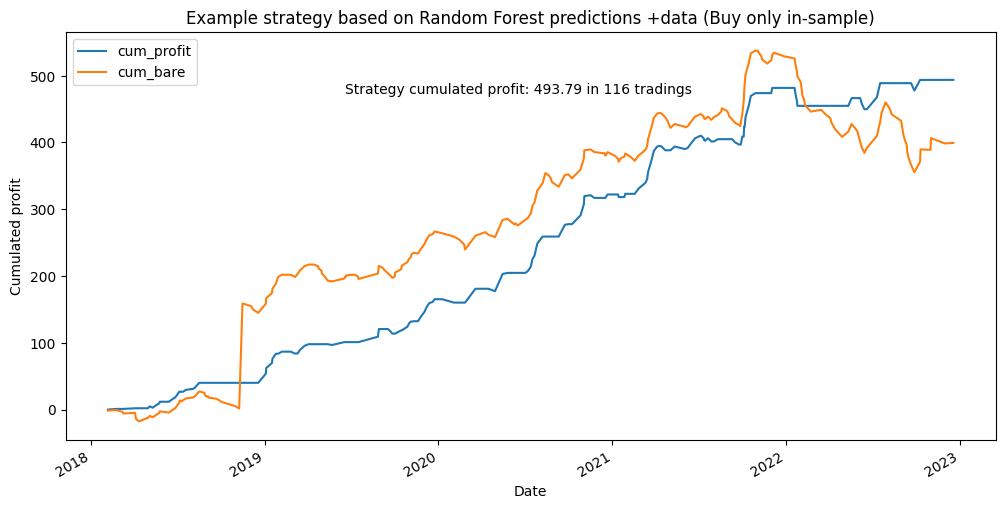

In [56]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on Random Forest predictions +data (Buy only in-sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

### Out-of-sample predictions

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df.values,
    target.values.flatten(),
    test_size=0.2,
    random_state=1968,
    shuffle=False,
)

In [58]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("rf", CatBoostClassifier(**study.best_params, silent=True)),
    ]
)

In [59]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 <catboost.core.CatBoostClassifier object at 0x137a322d0>)])

In [60]:
predictions = pipe.predict(X_test)

In [61]:
pipe.score(X_test, y_test)

0.44223107569721115

              precision    recall  f1-score   support

           0       0.73      0.33      0.45       177
           1       0.31      0.72      0.43        74

    accuracy                           0.44       251
   macro avg       0.52      0.52      0.44       251
weighted avg       0.61      0.44      0.45       251



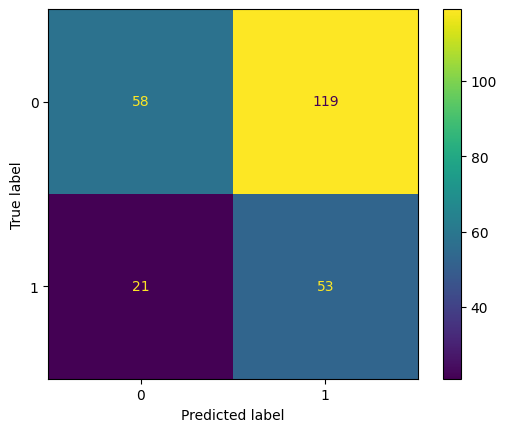

In [62]:
display_report(y_test, predictions)

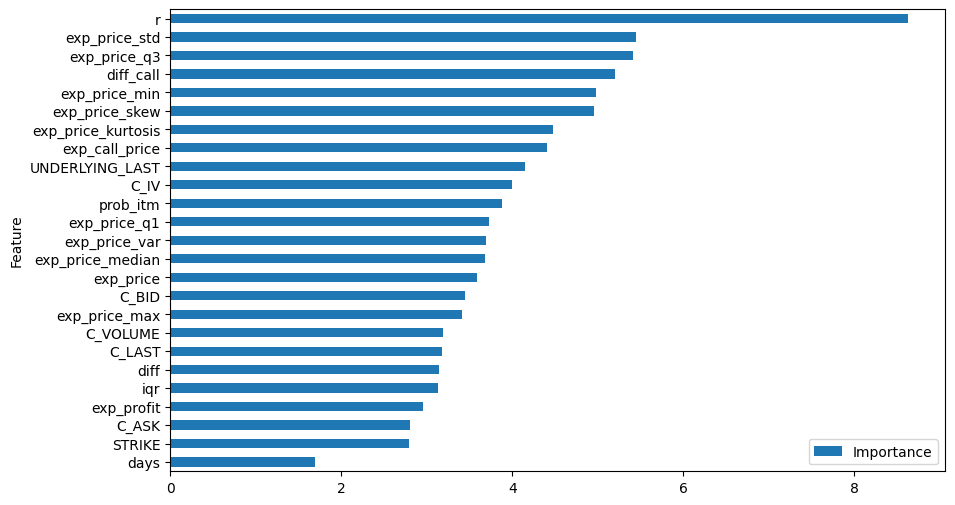

In [63]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [64]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [65]:
strategy = []
date_idx = []
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = new_df.iloc[-i, :].to_dict()
    quote_date = new_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    final_price = spy.loc[exp_date, "Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [66]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

In [67]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [68]:
strategy_df

,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,,
2022-01-03,0,478.0,4.81,10.248337,2022-01-24,439.839996,0.000000,-4.810000,0.000000,-4.810000
2022-01-04,0,478.0,4.80,9.610177,2022-01-24,439.839996,0.000000,-4.800000,0.000000,-9.610000
2022-01-05,1,468.0,8.14,10.191128,2022-01-26,433.380005,-8.140000,-8.140000,-8.140000,-17.750000
2022-01-06,1,468.0,7.00,9.657596,2022-01-26,433.380005,-7.000000,-7.000000,-15.140000,-24.750000
2022-01-07,1,466.0,7.56,9.927762,2022-01-28,441.950012,-7.560000,-7.560000,-22.700000,-32.310000
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0,383.0,8.00,8.453400,2023-01-13,398.500000,0.000000,7.500000,-415.599998,-525.980022
2022-12-26,1,383.0,7.96,8.096501,2023-01-13,398.500000,7.540000,7.540000,-408.059998,-518.440022
2022-12-28,1,377.0,8.75,8.526141,2023-01-20,395.880005,10.130005,10.130005,-397.929993,-508.310017


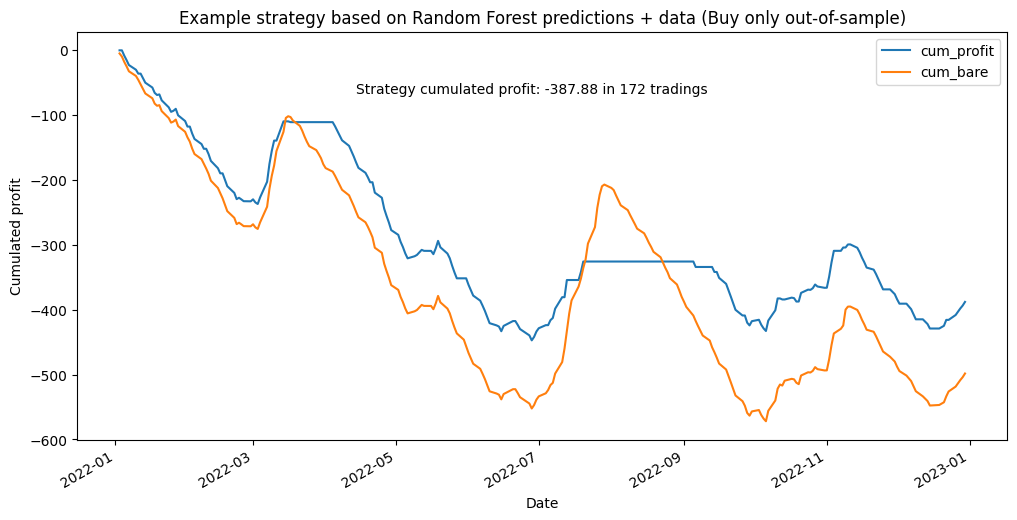

In [69]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on Random Forest predictions + data (Buy only out-of-sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

## Compare the two predictions

In [70]:
mask_in = (compare_df["bare_rf_pred_in"] - compare_df["mmar_rf_pred_in"]).astype(bool)
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [71]:
compare_df[mask_in]

,bare_rf_pred_in,bare_rf_pred_out,mmar_rf_pred_in,mmar_rf_pred_out
3,1,0,0,1
16,0,1,1,1
21,1,1,0,1
23,1,1,0,1
24,0,1,1,1
26,1,1,0,1
39,0,1,1,1
40,0,1,1,1
47,0,1,1,1
50,0,0,1,1


In [72]:
compare_df[mask_in].shape

(47, 4)

In [73]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_in,bare_rf_pred_out,mmar_rf_pred_in,mmar_rf_pred_out
2,0,0,0,1
3,1,0,0,1
4,1,0,1,1
5,0,0,0,1
8,0,0,0,1
...,...,...,...,...
245,0,0,0,1
247,1,0,1,1
248,1,0,1,1
249,0,0,0,1


In [74]:
compare_df[mask_out].shape

(138, 4)

In [75]:
compare_df.sum(axis=0)

bare_rf_pred_in     119
bare_rf_pred_out     42
mmar_rf_pred_in     116
mmar_rf_pred_out    172
dtype: int64